# Linear Regression

This notebook implements a Linear Regression for automated essay scoring using TF-IDF features from both prompts and essays.

## Key Findings

The best-performing model, tuned via grid search, achieved an R² score of 0.2634 on the test set, indicating limited but present predictive power. When the regression output was evaluated as a classification task by rounding predictions to integer band scores, the model reached an accuracy of 31.72%, showing that exact score prediction remains a challenge.

## Import and Setup

---

In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
import nltk
import re
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

## Data Import

---

In [28]:
df_train = pd.read_csv("../data/clean_train.csv")
df_test = pd.read_csv("../data/clean_test.csv")

In [29]:
df_train.shape

(9048, 14)

## Extracting the necessary features

---

In [30]:
prompts_train = df_train["prompt"]
essays_train = df_train["essay"]

y_train = df_train["band_score"]

prompts_test = df_test["prompt"]
essays_test = df_test["essay"]

y_test = df_test["band_score"]

## Oversampling

---

Before oversampling:
Train shape: (9048, 14)
Train class distribution:
band_score
4.0     849
4.5     556
5.0     540
5.5     888
6.0    1375
6.5    1493
7.0    1315
7.5    1138
8.0     488
8.5     406
Name: count, dtype: int64


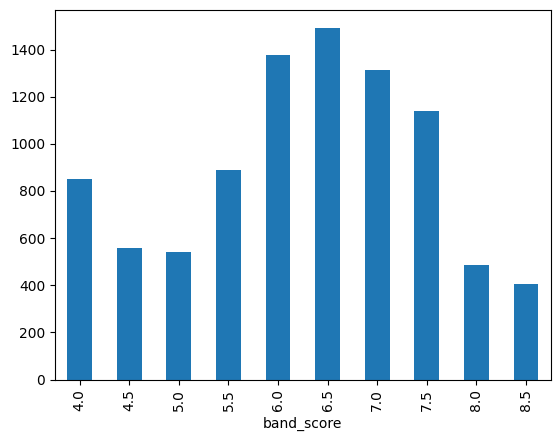

In [31]:
band_counts = df_train["band_score"].value_counts().sort_index()
band_counts.plot(kind="bar")
print("Before oversampling:")
print(f"Train shape: {df_train.shape}")
print(
    f"Train class distribution:\n{df_train['band_score'].value_counts().sort_index()}"
)

In [32]:
def random_oversample(df, target_column, random_state=42):
    """
    Randomly oversample minority classes to match the majority class
    """
    np.random.seed(random_state)

    # Get class counts
    class_counts = df["band_score"].value_counts()
    max_count = class_counts.max()

    oversampled_dfs = []

    for class_value in class_counts.index:
        class_df = df[df["band_score"] == class_value]
        current_count = len(class_df)

        if current_count < max_count:
            # Calculate how many more samples we need
            needed_samples = max_count - current_count

            # Randomly sample with replacement
            additional_samples = class_df.sample(
                n=needed_samples, replace=True, random_state=random_state
            )

            # Combine original and additional samples
            class_df_oversampled = pd.concat(
                [class_df, additional_samples], ignore_index=True
            )
        else:
            class_df_oversampled = class_df

        oversampled_dfs.append(class_df_oversampled)

    # Combine all classes
    result_df = pd.concat(oversampled_dfs, ignore_index=True)

    # Shuffle the dataset
    result_df = result_df.sample(frac=1, random_state=random_state).reset_index(
        drop=True
    )

    return result_df


After oversampling:
Train shape: (14930, 14)
Train class distribution:
band_score
4.0    1493
4.5    1493
5.0    1493
5.5    1493
6.0    1493
6.5    1493
7.0    1493
7.5    1493
8.0    1493
8.5    1493
Name: count, dtype: int64


<Axes: xlabel='band_score'>

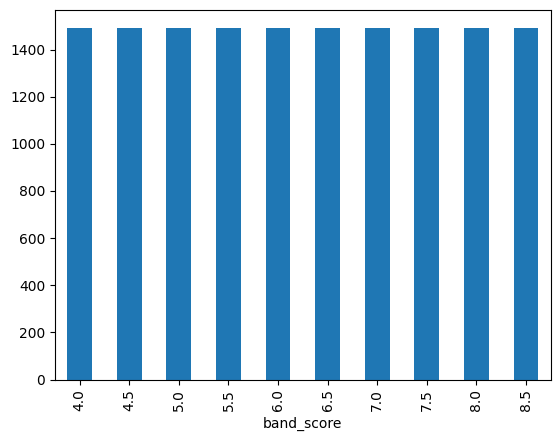

In [33]:
# Apply oversampling to training data only
df_train = random_oversample(df_train, "band_score", random_state=42)

print("\nAfter oversampling:")
print(f"Train shape: {df_train.shape}")
print(
    f"Train class distribution:\n{df_train['band_score'].value_counts().sort_index()}"
)
band_counts = df_train["band_score"].value_counts().sort_index()
band_counts.plot(kind="bar")

## Split X and y

---

In [34]:
X_train_df = df_train[["prompt", "essay"]]
y_train_series = (df_train["band_score"] * 2).astype(int)
X_test_df = df_test[["prompt", "essay"]]
y_test_series = (df_test["band_score"] * 2).astype(int)

## Building the text preprocessing pipeline

---

In [35]:
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

# Load stopwords globally once
ENGLISH_STOPWORDS = set(stopwords.words("english"))


def preprocess_text_fn(text):
    if isinstance(text, str):
        # Convert escape sequences
        text = text.replace("\\\\r\\\\n", " ").replace("\\\\n", " ")
        # Remove special characters and numbers
        text = re.sub(r"[^\\\\w\\\\s]", "", text)
        # Convert to lowercase
        text = text.lower()
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords using the global set
        tokens = [word for word in tokens if word not in ENGLISH_STOPWORDS]
        return " ".join(tokens)
    return ""


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # X is expected to be a pandas Series
        if isinstance(X, pd.Series):
            return X.apply(preprocess_text_fn)
        # If X is a list:
        return pd.Series(X).apply(preprocess_text_fn)

In [36]:
prompt_pipeline = Pipeline(
    [
        ("preprocess", TextPreprocessor()),
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=word_tokenize, lowercase=True, ngram_range=(1, 3), min_df=2
            ),
        ),
    ]
)

essay_pipeline = Pipeline(
    [
        ("preprocess", TextPreprocessor()),
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=word_tokenize, lowercase=True, ngram_range=(1, 3), min_df=2
            ),
        ),
    ]
)

## Vectorizing and concatinating

---

In [37]:
feature_preprocessor = ColumnTransformer(
    transformers=[
        (
            "prompt_features",
            prompt_pipeline,
            "prompt",
        ),
        (
            "essay_features",
            essay_pipeline,
            "essay",
        ),
    ],
    remainder="drop",
)

In [38]:
combined_pipeline = Pipeline(
    [
        ("features", feature_preprocessor),
        ("scaler", StandardScaler(with_mean=False)),
        ("linreg", Ridge(alpha=1.0, random_state=0)),
    ]
)

In [39]:
param_grid = {
    "features__prompt_features__tfidf__max_df": [0.9, 0.95],
    "features__prompt_features__tfidf__min_df": [2, 5],
    "features__prompt_features__tfidf__ngram_range": [(1, 2), (1, 3)],
    "features__essay_features__tfidf__max_df": [0.9, 0.95],
    "linreg__alpha": [0.1, 1.0, 10.0, 100.0],
}

In [40]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    combined_pipeline, param_grid, cv=3, scoring="r2", verbose=1, n_jobs=-1
)
grid_search.fit(X_train_df, y_train_series)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/Users/finnferchau/dev/team-10/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/finnferchau/dev/team-10/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/finnferchau/dev/team-10/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/finnferchau/dev/team-10/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/finnferchau/dev/team-10/.env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' 

Best parameters: {'features__essay_features__tfidf__max_df': 0.9, 'features__prompt_features__tfidf__max_df': 0.9, 'features__prompt_features__tfidf__min_df': 2, 'features__prompt_features__tfidf__ngram_range': (1, 2), 'linreg__alpha': 100.0}
Best cross-validation score: 0.4956422257782702


In [41]:
best_model = grid_search.best_estimator_

In [42]:
y_pred = best_model.predict(X_test_df)

In [43]:
print("MSE:", mean_squared_error(y_test_series, y_pred))
print("MAE:", mean_absolute_error(y_test_series, y_pred))
print("R² Score:", r2_score(y_test_series, y_pred))

MSE: 1.9190200952905812
MAE: 0.833279315528899
R² Score: 0.6657909579692716


## Evaluate as Classification

---

Classification Accuracy: 0.5330

Classification Report:
              precision    recall  f1-score   support

           8       1.00      0.57      0.72        46
           9       1.00      0.81      0.89        31
          10       0.73      0.40      0.52        20
          11       0.70      0.52      0.60        61
          12       0.34      0.42      0.37        67
          13       0.31      0.67      0.42        81
          14       0.61      0.34      0.44        65
          15       0.81      0.37      0.51        46
          16       0.94      0.76      0.84        21
          17       0.93      0.88      0.90        16

    accuracy                           0.53       454
   macro avg       0.74      0.57      0.62       454
weighted avg       0.65      0.53      0.55       454



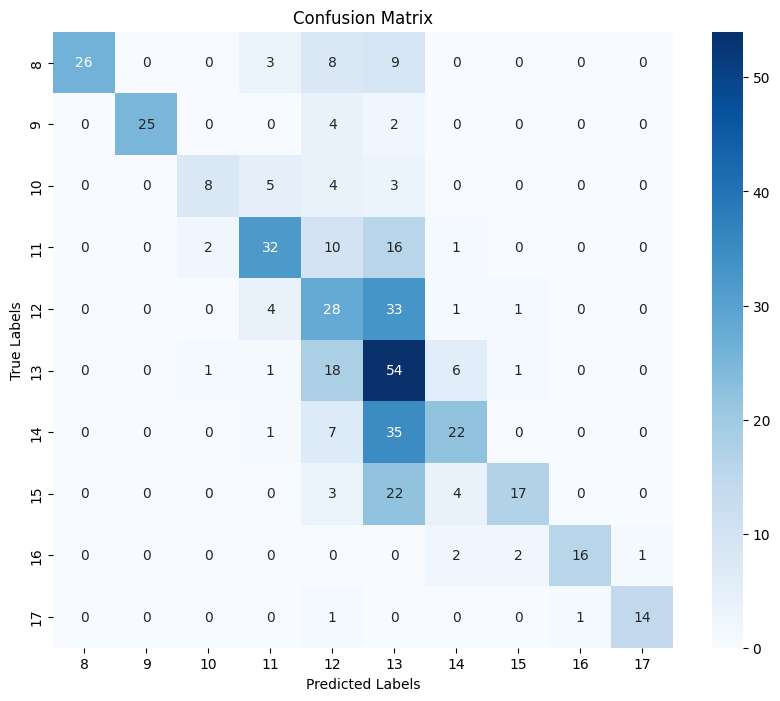

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def confusion_matrix_plot(cm, class_labels):
    """
    Plot a confusion matrix.

    Args:
        cm (np.ndarray): The confusion matrix.
        class_labels (list): The class labels.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Convert regression predictions to classification labels
y_pred_class = np.round(y_pred).astype(int)
y_test_class = y_test_series.astype(int)

# Calculate classification metrics
accuracy = accuracy_score(y_test_class, y_pred_class)
class_report = classification_report(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

print(f"Classification Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(class_report)

# Get unique classes for labels
unique_classes = sorted(list(set(y_test_class.tolist() + y_pred_class.tolist())))
class_labels = [str(cls) for cls in unique_classes]

# Plot confusion matrix
confusion_matrix_plot(conf_matrix, class_labels)


### [`Click here to go back to the Homepage`](../Homepage.md)